In [1]:

from sklearn.metrics import roc_curve, auc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ppscore as pps1
from sklearn import preprocessing
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
import sklearn.metrics as metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer

from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.model_selection import cross_val_score
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
import pandas as pd
import numpy as np
import ppscore as pps

In [12]:
def randomForestModel():
    drop_column = ['OBJECTID', 'X', 'Y', 'event_unique_id', 'City',
                   'Location_Type', 'NeighbourhoodName', 'Latitude', 'Longitude', 'OBJECTID_1']

    data = pd.read_csv('./../code/Bicycle_Thefts.csv')

    X1 = data['Bike_Model']

    Y1 = data['Status']

    data.drop(drop_column, axis=1, inplace=True)
# Neighbourhood is identical with Hood ID
    data.rename(columns={'Hood ID': 'Neighbourhood'}, inplace=True)

    data['Occurrence_Date'] = pd.to_datetime(
        data['Occurrence_Date']).dt.time  # change data type
    data['Bike_Colour'].fillna('other', inplace=True)  # fill nan value
    data['Cost_of_Bike'].replace(
        0, np.nan, inplace=True)  # zero is also invalid

    unknown_make = ['UK', 'NULL', 'UNKNOWN MAKE', 'UNKNOWN', 'NONE', 'NO', 'UNKNOWNN',
                    'UNKONWN', 'UNKOWN', 'UNKNONW', '-', 'UNKNOW', 'NO NAME', '?']  # all typos stand for known
    giant = data['Bike_Make'][data['Bike_Make'].str.contains(
        'giant', case=False, na=False)].unique().tolist()  # alias of giant
    giant.append('GI')

    data['Bike_Make'].replace(giant, 'GIANT', inplace=True)
    data['Bike_Make'].replace('OT', 'OTHER', inplace=True)
    data['Bike_Make'].replace(unknown_make, np.nan, inplace=True)

# transform non-numeric data
    encoder = preprocessing.LabelEncoder()
    data['Bike_Type'] = encoder.fit_transform(
        data['Bike_Type'])  # only numerical values for KNNImputer
    data['Bike_Make'] = pd.Series(encoder.fit_transform(data['Bike_Make'][data['Bike_Make'].notna(
    )]), index=data['Bike_Make'][data['Bike_Make'].notna()].index)  # only numerical values for KNNImputer
    data[['Bike_Type', 'Bike_Speed', 'Cost_of_Bike']] = KNNImputer(
    ).fit_transform(data[['Bike_Type', 'Bike_Speed', 'Cost_of_Bike']])
    data[['Bike_Type', 'Bike_Speed', 'Bike_Make']] = KNNImputer(
    ).fit_transform(data[['Bike_Type', 'Bike_Speed', 'Bike_Make']])

# Convert cost to cost catagory
    low = data['Cost_of_Bike'].quantile(.25)
    average = data['Cost_of_Bike'].quantile(.5)
    high = data['Cost_of_Bike'].quantile(.75)
    data['cost_catag'] = np.where(data['Cost_of_Bike'] <= low, 'low', np.where((data['Cost_of_Bike'] > low) & (
        data['Cost_of_Bike'] <= average), 'average', np.where((data['Cost_of_Bike'] > average) & (data['Cost_of_Bike'] <= high), 'high', 'luxury')))

# upcycling of data
    data['Status'].replace('STOLEN', 0, inplace=True)
    data['Status'].replace(['UNKNOWN', 'RECOVERED'], 1, inplace=True)

    print(data.head())

# encoding categorical features
    categorical_cols = [
        col for col in data.columns if data[col].dtype == 'object']
    for col in categorical_cols:
        data[col] = encoder.fit_transform(data[col])
    X, Y = data.drop('Status', axis=1), data['Status']
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=.2)

    rf = RandomForestClassifier(n_estimators=100, random_state=0)
    rf.fit(x_train, y_train)

    rf_y_pred = rf.predict(x_test)
    print('Accuracy of RandomForest is:', accuracy_score(y_test, rf_y_pred))

    # Random forest classifier with tuning
    params_grid = {
        'n_estimators': range(10, 100, 10),
        'max_features': ['auto', 'sqrt', 'log2'],
        'max_depth': range(1, 10),
        'min_samples_split': range(2, 10),
        'min_samples_leaf': range(1, 10),
    }

    rs = RandomizedSearchCV(
        rf,
        params_grid,
        n_iter=10,
        cv=10,
        scoring='accuracy',
        return_train_score=False,
        verbose=2,
        random_state=88)

    search = rs.fit(x_train, y_train)

    # best parameters & estimator
    print("Best Params: ", search.best_params_)
    print("Best estimators are: ", search.best_estimator_)

    accuracy = search.best_score_ * 100
    print(
        "Accuracy for training dataset with tuning is : {:.2f}%".format(accuracy))

    # Training the Random Forest Classification model on the Training Set with best param
    fine_tuned_model = search.best_estimator_.fit(x_train, y_train)
    # Predicting the Test set results
    rf_y_pred = fine_tuned_model.predict(x_test)
    # predict_proba to return numpy array with two columns for a binary classification for N and P
    rf_y_scores = fine_tuned_model.predict_proba(x_test)

    # roc curve
    fpr, tpr, threshold = roc_curve(y_test, rf_y_scores[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title('ROC Curve of RandomForest')
    print('Classification Report(N): \n',
          classification_report(y_test, rf_y_pred))
    print('Confusion Matrix(N): \n', confusion_matrix(y_test, rf_y_pred))
    print('Accuracy(N): \n', metrics.accuracy_score(y_test, rf_y_pred))

    # Comparing the Real Values with Predicted Values
    df = pd.DataFrame({'Real Values': y_test, 'Predicted Values': rf_y_pred})
    print(df)


         Primary_Offence Occurrence_Date  Occurrence_Year Occurrence_Month  \
0  THEFT UNDER - BICYCLE        00:00:00             2016          January   
1            THEFT UNDER        00:00:00             2016          January   
2            THEFT UNDER        00:00:00             2016          January   
3            THEFT UNDER        00:00:00             2016          January   
4            THEFT UNDER        00:00:00             2016          January   

  Occurrence_DayOfWeek  Occurrence_DayOfMonth  Occurrence_DayOfYear  \
0             Thursday                     14                    14   
1               Friday                     15                    15   
2             Saturday                     16                    16   
3              Tuesday                     12                    12   
4             Thursday                     14                    14   

   Occurrence_Hour             Report_Date  Report_Year  ... Hood_ID  \
0                9  2016/01/15 0

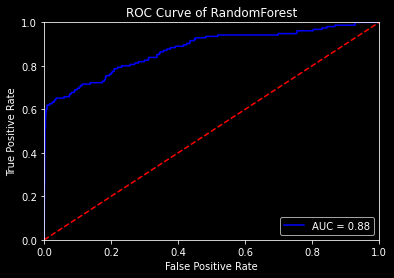

In [13]:
randomForestModel()